# Convert and Optimize YOLOv12 real-time object detection with OpenVINO™

Real-time object detection is often used as a key component in computer vision systems.
Applications that use real-time object detection models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.


This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch YOLOv12 with OpenVINO. We consider the steps required for object detection scenario. You can find more details about model on [model page](https://docs.ultralytics.com/models/yolo12/) in Ultralytics documentation

The tutorial consists of the following steps:
- Prepare the PyTorch model.
- Download and prepare a dataset.
- Validate the original model.
- Convert the PyTorch model to OpenVINO IR.
- Prepare and run optimization pipeline.
- Compare performance of the FP32 and quantized models.
- Other optimization possibilities with OpenVINO api
- Live demo



#### Table of contents:

- [Get PyTorch model](#Get-PyTorch-model)
    - [Prerequisites](#Prerequisites)
- [Instantiate model](#Instantiate-model)
    - [Convert model to OpenVINO IR](#Convert-model-to-OpenVINO-IR)
    - [Verify model inference](#Verify-model-inference)
    - [Select inference device](#Select-inference-device)
    - [Test on single image](#Test-on-single-image)
- [Optimize model using NNCF Post-training Quantization API](#Optimize-model-using-NNCF-Post-training-Quantization-API)
    - [Validate Quantized model inference](#Validate-Quantized-model-inference)
- [Compare the Original and Quantized Models](#Compare-the-Original-and-Quantized-Models)
    - [Compare performance object detection models](#Compare-performance-object-detection-models)
- [Next steps](#Next-steps)
    - [Async inference pipeline](#Async-inference-pipeline)
- [Live demo](#Live-demo)
    - [Run Live Object Detection](#Run-Live-Object-Detection)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/yolov12-optimization/yolov12-object-detection.ipynb" />


## Get PyTorch model
[back to top ⬆️](#Table-of-contents:)

Generally, PyTorch models represent an instance of the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv12 nano model (also known as `yolo12n`) pre-trained on a COCO dataset, which is available in this [repo](https://github.com/ultralytics/ultralytics). Similar steps are also applicable to other YOLOv12 models.
Typical steps to obtain a pre-trained model:
1. Create an instance of a model class.
2. Load a checkpoint state dict, which contains the pre-trained model weights.
3. Turn the model to evaluation for switching some operations to inference mode.

In this case, Ultralytics provides an API that enables converting the YOLOv12 model to OpenVINO IR. Therefore, we do not need to do these steps manually.

#### Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install necessary packages.

In [ ]:
import platform


if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"


%pip install -qU --pre "openvino>2025.0.0" "nncf>=2.15.0" --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly
%pip install -q "torch>=2.1" "torchvision>=0.16" tqdm opencv-python --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "git+https://github.com/aleksandr-mokrov/ultralytics.git@openvino-version-restriction"

Import required utility functions.
The lower cell will download the `notebook_utils` Python module from GitHub.

In [ ]:
from pathlib import Path
import requests


if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )

    open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, VideoPlayer, device_widget, quantization_widget

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("yolov12-object-detection.ipynb")

In [3]:
# Download a test sample
IMAGE_PATH = Path("./data/coco_bike.jpg")

if not IMAGE_PATH.exists():
    download_file(
        url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg",
        filename=IMAGE_PATH.name,
        directory=IMAGE_PATH.parent,
    )

## Instantiate model
[back to top ⬆️](#Table-of-contents:)

There are [several models](https://docs.ultralytics.com/tasks/detect/) available in the original repository, targeted for different tasks. For loading the model, required to specify a path to the model checkpoint. It can be some local path or name available on models hub (in this case model checkpoint will be downloaded automatically). 

You can select one of represented model using widget bellow:

In [4]:
import ipywidgets as widgets

model_id = ["yolo12n", "yolo12s", "yolo12m", "yolo12l", "yolo12x"]

model_name = widgets.Dropdown(options=model_id, value=model_id[0], description="Model")

model_name

Dropdown(description='Model', options=('yolo12n', 'yolo12s', 'yolo12m', 'yolo12l', 'yolo12x'), value='yolo12n'…

Making prediction, the model accepts a path to input image and returns list with Results class object. Results contains boxes for object detection model. Also it contains utilities for processing results, for example, `plot()` method for drawing.

Let us consider the examples:


image 1/1 /home/ekaterina/checker/openvino_notebooks/notebooks/yolov12-optimization/data/coco_bike.jpg: 480x640 2 bicycles, 2 cars, 1 dog, 68.2ms
Speed: 1.8ms preprocess, 68.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


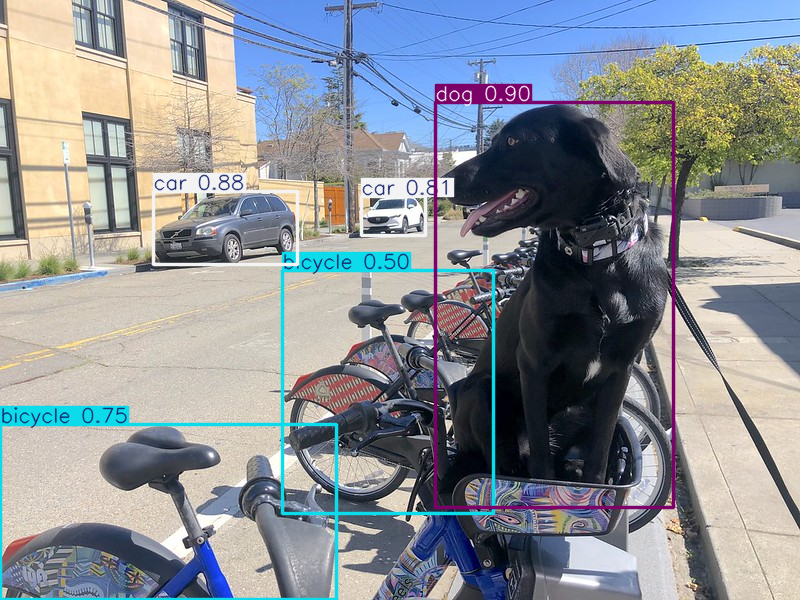

In [5]:
from PIL import Image
from ultralytics import YOLO

DET_MODEL_NAME = model_name.value

det_model = YOLO(f"{DET_MODEL_NAME}.pt")
det_model.to("cpu")
label_map = det_model.model.names

res = det_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

### Convert model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

Ultralytics provides API for convenient model exporting to different formats including OpenVINO IR. `model.export` is responsible for model conversion. We need to specify the format, and additionally, we can preserve dynamic shapes in the model.

In [6]:
# object detection model
det_model_path = Path(f"{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml")
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=True)

Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i9-12900K)

PyTorch: starting from 'yolo12n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.3 MB)

OpenVINO: starting export with openvino 2025.1.0-18311-da00e90afb7...
OpenVINO: export success ✅ 1.8s, saved as 'yolo12n_openvino_model/' (5.7 MB)

Export complete (1.9s)
Results saved to /home/ekaterina/checker/openvino_notebooks/notebooks/yolov12-optimization
Predict:         yolo predict task=detect model=yolo12n_openvino_model imgsz=640 half 
Validate:        yolo val task=detect model=yolo12n_openvino_model imgsz=640 data=None half 
Visualize:       https://netron.app


### Verify model inference
[back to top ⬆️](#Table-of-contents:)

We can reuse the base model pipeline for pre- and postprocessing just replacing the inference method where we will use the IR model for inference.

### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO

In [7]:
device = device_widget()

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

### Test on single image
[back to top ⬆️](#Table-of-contents:)

Now, once we have defined preprocessing and postprocessing steps, we are ready to check model prediction for object detection.

Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i9-12900K)
Loading yolo12n_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 /home/ekaterina/checker/openvino_notebooks/notebooks/yolov12-optimization/data/coco_bike.jpg: 640x640 4 bicycles, 2 cars, 1 dog, 26.6ms
Speed: 1.7ms preprocess, 26.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


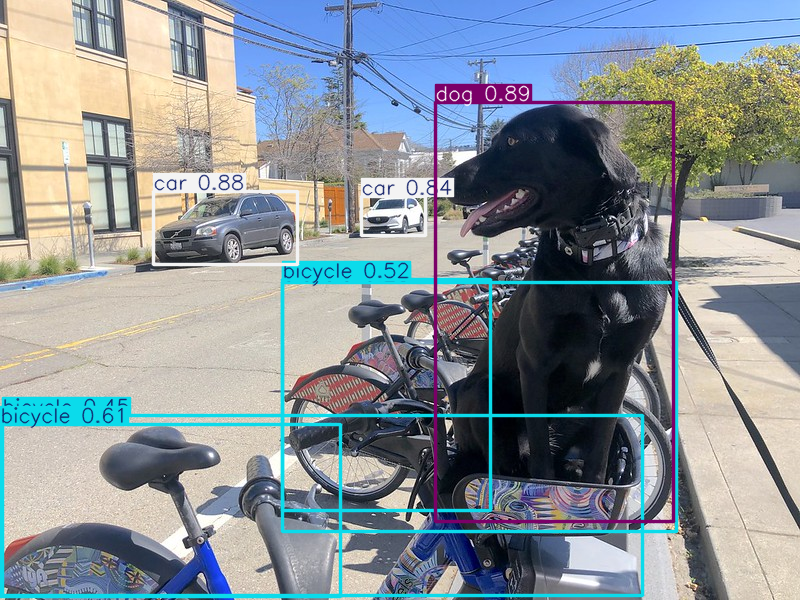

In [8]:
import openvino as ov

core = ov.Core()

det_ov_model = core.read_model(det_model_path)

ov_config = {}
if device.value != "CPU":
    det_ov_model.reshape({0: [1, 3, 640, 640]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
det_compiled_model = core.compile_model(det_ov_model, device.value, ov_config)
det_model = YOLO(det_model_path.parent, task="detect")

if det_model.predictor is None:
    custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
    args = {**det_model.overrides, **custom}
    det_model.predictor = det_model._smart_load("predictor")(overrides=args, _callbacks=det_model.callbacks)
    det_model.predictor.setup_model(model=det_model.model)

det_model.predictor.model.ov_compiled_model = det_compiled_model

res = det_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

## Optimize model using NNCF Post-training Quantization API
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize model.

The optimization process contains the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting an optimized model.
3. Serialize OpenVINO IR model, using the `openvino.runtime.serialize` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [9]:
int8_model_det_path = Path(f"{DET_MODEL_NAME}_openvino_int8_model/{DET_MODEL_NAME}.xml")
quantized_det_model = None

to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [10]:
if not Path("skip_kernel_extension.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
    )
    open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

In [ ]:
%%skip not $to_quantize.value

from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.converter import coco80_to_coco91_class
from ultralytics.data.utils import check_det_dataset
from zipfile import ZipFile

from ultralytics.data.utils import DATASETS_DIR


DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"
CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/v8.1.0/ultralytics/cfg/datasets/coco.yaml"

OUT_DIR = DATASETS_DIR

DATA_PATH = OUT_DIR / "val2017.zip"
LABELS_PATH = OUT_DIR / "coco2017labels-segments.zip"
CFG_PATH = OUT_DIR / "coco.yaml"

if not int8_model_det_path.exists():
    if not (OUT_DIR / "coco/labels").exists():
        download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
        download_file(LABELS_URL, LABELS_PATH.name, LABELS_PATH.parent)
        download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)
        with ZipFile(LABELS_PATH, "r") as zip_ref:
            zip_ref.extractall(OUT_DIR)
        with ZipFile(DATA_PATH, "r") as zip_ref:
            zip_ref.extractall(OUT_DIR / "coco/images")


    args = get_cfg(cfg=DEFAULT_CFG)
    args.data = str(CFG_PATH)
    det_validator = det_model.task_map[det_model.task]["validator"](args=args)
    det_validator.data = check_det_dataset(args.data)
    det_validator.stride = 32
    det_data_loader = det_validator.get_dataloader(OUT_DIR / "coco", 1)

    det_validator.is_coco = True
    det_validator.class_map = coco80_to_coco91_class()
    det_validator.names = label_map
    det_validator.metrics.names = det_validator.names
    det_validator.nc = 80

Reuse validation dataloader in accuracy testing for quantization. 
For that, it should be wrapped into the `nncf.Dataset` object and define a transformation function for getting only input tensors.

In [12]:
%%skip not $to_quantize.value

import nncf
from typing import Dict


if not int8_model_det_path.exists():


    def transform_fn(data_item:Dict):
        """
        Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
        Parameters:
        data_item: Dict with data item produced by DataLoader during iteration
        Returns:
            input_tensor: Input data for quantization
        """
        input_tensor = det_validator.preprocess(data_item)['img'].numpy()
        return input_tensor


    quantization_dataset = nncf.Dataset(det_data_loader, transform_fn)

The `nncf.quantize` function provides an interface for model quantization. It requires an instance of the OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for the configuration quantization process (number of samples for quantization, preset, ignored scope, etc.) can be provided. Ultralytics modes contain non-ReLU activation functions, which require asymmetric quantization of activations. To achieve a better result, we will use a `mixed` quantization preset. It provides symmetric quantization of weights and asymmetric quantization of activations. For more accurate results, we should keep the operation in the postprocessing subgraph in floating point precision, using the `ignored_scope` parameter.

>**Note**: Model post-training quantization is time-consuming process. Be patient, it can take several minutes depending on your hardware.

In [13]:
%%skip not $to_quantize.value

if not int8_model_det_path.exists():
    ignored_scope = nncf.IgnoredScope( # post-processing
        subgraphs=[
            nncf.Subgraph(inputs=[f"__module.model.21/aten::cat/Concat",
                                f"__module.model.21/aten::cat/Concat_1",
                                f"__module.model.21/aten::cat/Concat_2"],
                        outputs=[f"__module.model.21/aten::cat/Concat_7"])
        ]
    )

    # Detection model
    quantized_det_model = nncf.quantize(
        det_ov_model,
        quantization_dataset,
        preset=nncf.QuantizationPreset.MIXED,
        ignored_scope=ignored_scope
    )
    print(f"Quantized detection model will be saved to {int8_model_det_path}")
    ov.save_model(quantized_det_model, str(int8_model_det_path))

INFO:nncf:108 ignored nodes were found by subgraphs in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 281 __module.model.21/aten::cat/Concat
INFO:nncf:Not adding activation input quantizer for operation: 315 __module.model.21/aten::view/Reshape_3
INFO:nncf:Not adding activation input quantizer for operation: 586 __module.model.21/aten::cat/Concat_1
INFO:nncf:Not adding activation input quantizer for operation: 601 __module.model.21/aten::view/Reshape_4
INFO:nncf:Not adding activation input quantizer for operation: 677 __module.model.21/aten::cat/Concat_2
INFO:nncf:Not adding activation input quantizer for operation: 680 __module.model.21/aten::view/Reshape_5
INFO:nncf:Not adding activation input quantizer for operation: 352 __module.model.21/aten::cat/Concat_4
INFO:nncf:Not adding activation input quantizer for operation: 386 __module.model.21/prim::ListUnpack
INFO:nncf:Not adding activation input quantizer for operation: 423 __module.model.21.dfl/aten::vi

Output()

Output()

Quantized detection model will be saved to yolo12n_openvino_int8_model/yolo12n.xml


### Validate Quantized model inference
[back to top ⬆️](#Table-of-contents:)

`nncf.quantize` returns the OpenVINO Model class instance, which is suitable for loading on a device for making predictions. `INT8` model input data and output result formats have no difference from the floating point model representation. Therefore, we can reuse the same `detect` function defined above for getting the `INT8` model result on the image.

In [14]:
%%skip not $to_quantize.value

device


image 1/1 /home/ekaterina/checker/openvino_notebooks/notebooks/yolov12-optimization/data/coco_bike.jpg: 640x640 4 bicycles, 2 cars, 1 dog, 26.5ms
Speed: 2.5ms preprocess, 26.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


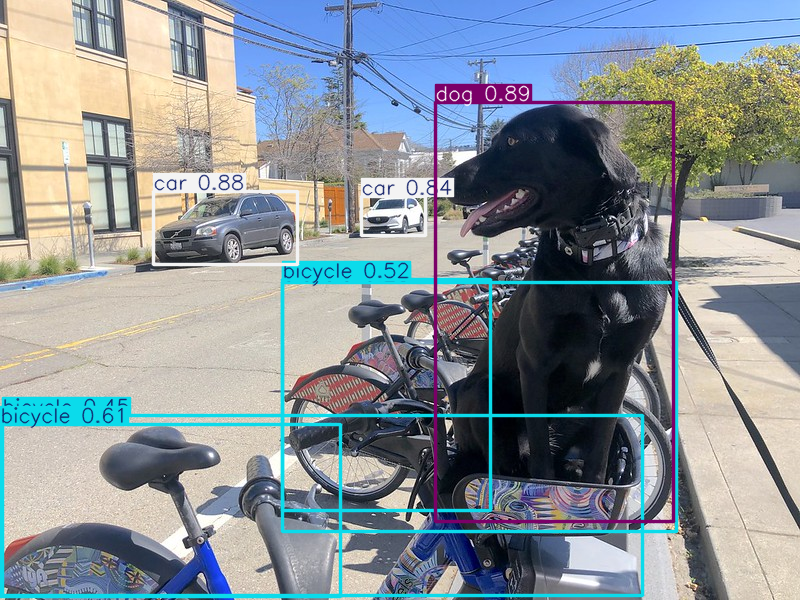

In [15]:
%%skip not $to_quantize.value

if quantized_det_model is None and int8_model_det_path.exists():
    quantized_det_model = core.read_model(int8_model_det_path)

ov_config = {}
if device.value != "CPU":
    quantized_det_model.reshape({0: [1, 3, 640, 640]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
quantized_det_compiled_model = core.compile_model(quantized_det_model, device.value, ov_config)


if det_model.predictor is None:
    custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
    args = {**det_model.overrides, **custom}
    det_model.predictor = det_model._smart_load("predictor")(overrides=args, _callbacks=det_model.callbacks)
    det_model.predictor.setup_model(model=det_model.model)

det_model.predictor.model.ov_compiled_model = det_compiled_model

res = det_model(IMAGE_PATH)
display(Image.fromarray(res[0].plot()[:, :, ::-1]))

## Compare the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)


### Compare performance object detection models
[back to top ⬆️](#Table-of-contents:)

Finally, use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html) to measure the inference performance of the `FP32` and `INT8` models.

> **Note**: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m <model_path> -d CPU -shape "<input_shape>"` to benchmark async inference on CPU on specific input data shape for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [16]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [17]:
if int8_model_det_path.exists():
    # Inference FP32 model (OpenVINO IR)
    !benchmark_app -m $det_model_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.1.0-18311-da00e90afb7
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2025.1.0-18311-da00e90afb7
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 19.69 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.21/aten::cat/Concat_7) : f32 / [...] / [?,84,21..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[ INFO ] Reshaping model: 'x

In [18]:
if int8_model_det_path.exists():
    # Inference INT8 model (OpenVINO IR)
    !benchmark_app -m $int8_model_det_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.1.0-18311-da00e90afb7
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2025.1.0-18311-da00e90afb7
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 29.22 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.21/aten::cat/Concat_7) : f32 / [...] / [1,84,8400]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[ INFO ] Reshaping model

## Next steps
[back to top ⬆️](#Table-of-contents:)

This section contains suggestions on how to additionally improve the performance of your application using OpenVINO.

### Async inference pipeline
[back to top ⬆️](#Table-of-contents:)

The key advantage of the Async API is that when a device is busy with inference, the application can perform other tasks in parallel (for example, populating inputs or scheduling other requests) rather than wait for the current inference to complete first. To understand how to perform async inference using openvino, refer to [Async API tutorial](../async-api/async-api.ipynb)

## Live demo
[back to top ⬆️](#Table-of-contents:)

The following code runs model inference on a video:

In [19]:
import collections
import time
from IPython import display
import cv2
import numpy as np


# Main processing function to run object detection.
def run_object_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=det_model,
    device=device.value,
    video_width: int = None,  # if not set the original size is used
):
    player = None
    ov_config = {}
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    compiled_model = core.compile_model(model, device, ov_config)

    if det_model.predictor is None:
        custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
        args = {**det_model.overrides, **custom}
        det_model.predictor = det_model._smart_load("predictor")(overrides=args, _callbacks=det_model.callbacks)
        det_model.predictor.setup_model(model=det_model.model)

    det_model.predictor.model.ov_compiled_model = compiled_model

    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break

            if video_width:
                # If the frame is larger than video_width, reduce size to improve the performance.
                # If more, increase size for better demo expirience.

                scale = video_width / max(frame.shape)
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Get the results.
            input_image = np.array(frame)

            start_time = time.time()
            detections = det_model(input_image, verbose=False)
            stop_time = time.time()
            frame = detections[0].plot()

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Live Object Detection
[back to top ⬆️](#Table-of-contents:)

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

>**NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a remote server (for example, in Binder or Google Colab service), the webcam will not work. By default, the lower cell will run model inference on a video file. If you want to try live inference on your webcam set `WEBCAM_INFERENCE = True`

Run the object detection:

In [20]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    VIDEO_SOURCE = "people.mp4"
    if not Path(VIDEO_SOURCE).exists():
        download_file(
            "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4",
            "people.mp4",
        )

In [21]:
device

Dropdown(description='Device:', options=('CPU', 'GPU', 'AUTO'), value='CPU')

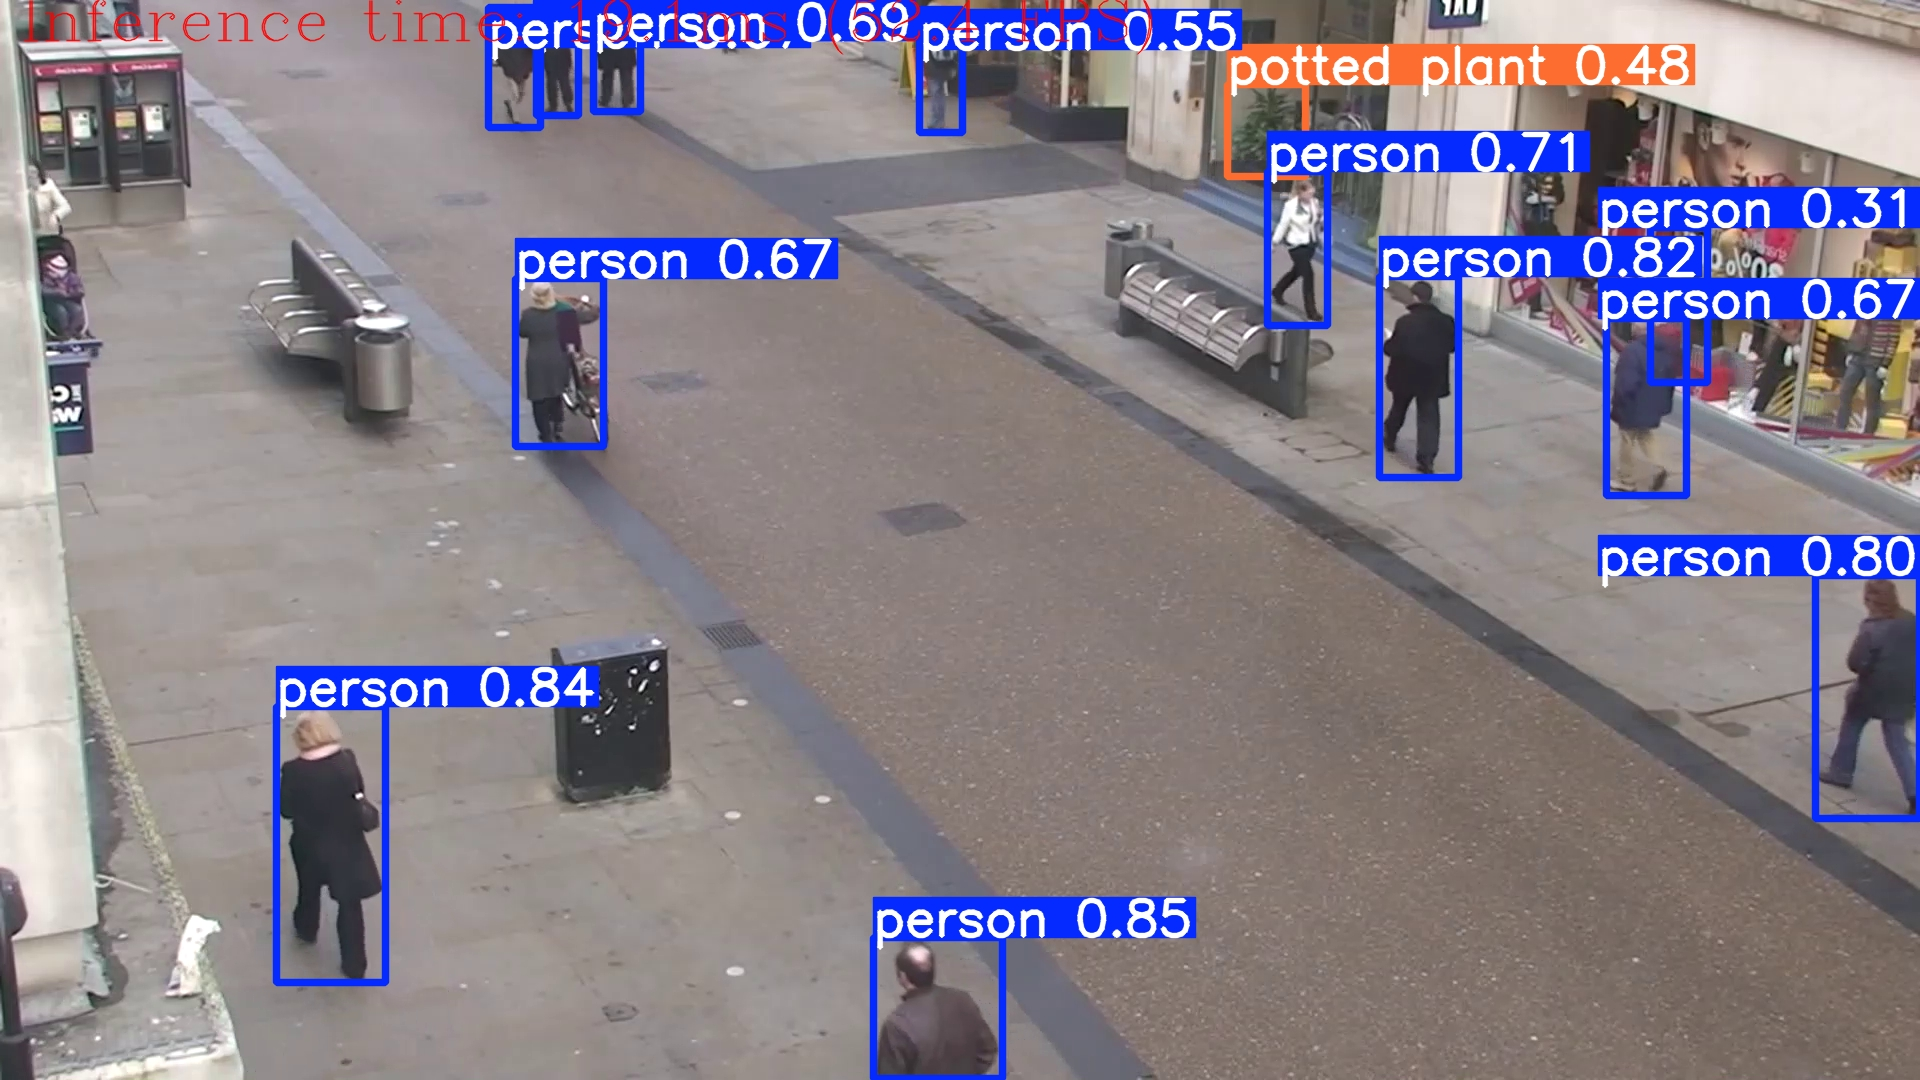

Source ended


In [22]:
run_object_detection(
    source=VIDEO_SOURCE,
    flip=True,
    use_popup=False,
    model=det_ov_model,
    device=device.value,
    # video_width=1280,
)